In [1]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import random
import warnings
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import sklearn
import cv2
from PIL import Image
import warnings


In [2]:
#hyper params
lr = 1e-3
wd = 1e-3
feature_extract = True
#lr = 1e-4
bs = 8
test_size = 0.15  # Test set size (20%)
val_size = 0.2   # Validation set size (25%)
num_epoch = 60
hardness_threshold = 0.60
lambda_u = 0.1  # Weighting factor for the unsupervised loss
patience = 4
classes = ['IRRELEVANT', 'RELEVANT'] #arranged in order of their placement in the folder
num_classes = len(classes)
path = './Balanced_Binary_Dataset'


In [3]:
def transform_denoise(image):
    # Denoising transformation (replace with your denoising algorithm)
    # Example: Apply Gaussian blur with a kernel size of 3
    denoised_image = transforms.functional.gaussian_blur(image, kernel_size=3,sigma=1.5)
    return denoised_image

def transform_enhance(image):
    # Image enhancement transformation (replace with your enhancement algorithm)
    # Example: Apply contrast enhancement
    enhanced_image = transforms.functional.adjust_contrast(image, contrast_factor=1.5)
    return enhanced_image

In [4]:

def get_dataset(path,val_split,test_split):
    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.Lambda(lambda x: transform_denoise(x)),
                                        transforms.Lambda(lambda x: transform_enhance(x)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomCrop(size=256),
                                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset= datasets.ImageFolder(path,transform=transform_strong)

    trainset,valset,testset = stratified(dataset)
    
    print("train :",len(trainset),"val :",len(valset),"test :",len(testset))

    
    return trainset,valset,testset

In [5]:
def stratified(dataset):
    # Get the labels and targets from the dataset
    labels = [label for _, label in dataset.samples]
    targets = dataset.targets

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_indices, test_indices = next(stratified_split.split(targets, labels))

    train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)
    testset = torch.utils.data.Subset(dataset, test_indices)
    
    # Further split the train-val dataset into train and validation sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
    train_indices, val_indices = next(stratified_split.split(train_val_dataset, [labels[idx] for idx in train_val_indices]))

    trainset = torch.utils.data.Subset(train_val_dataset, train_indices)
    valset = torch.utils.data.Subset(train_val_dataset, val_indices)
    
    return trainset,valset,testset

In [6]:
def train_model(trainset,valset, model, criterion, optimizer, scheduler_train , scheduler_val, num_epochs, bs, hardness_threshold):
    dataloaders_strong = {
        'train': data.DataLoader(trainset, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset, batch_size=bs, shuffle=True)
    }

    dataset_sizes_strong = {'train': len(trainset), 'val': len(valset)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epochs_without_improvement = 0  # Reset the counter since there is improvement

    # Lists to store entropy values for each epoch
    entropy_values_train = []
    entropy_values_val = []
    # Lists to store loss of each epoch
    E_loss_train = []
    E_loss_val = []
    E_accuracy_train = []
    E_accuracy_val = []
    # Lists to store balanced accuracy for training and validation phases
    balanced_acc_train = []
    balanced_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            all_labels = []
            all_preds = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                        
            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy

            # Iterate over data.
            for inputs, labels in dataloaders_strong[phase]:
                inputs = inputs.to(device)                
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # AdaMatch steps
                    if phase == 'train':
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore", category=UserWarning)
                            balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())


                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(preds.cpu().tolist())

                        # Backpropagation and optimization
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    else:
                                                
                        # Calculate hardness score for each sample in the batch
                        probabilities_hard = torch.softmax(outputs, dim=1)
                        hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

                        # Skip predictions if hardness score is greater than the threshold
                        skip_mask = hardness_scores <= hardness_threshold
                    
                    
                        if skip_mask.sum().item() > 0:
                            c += 1
                            inputs = inputs[skip_mask]
                            labels = labels[skip_mask]
                            preds = preds[skip_mask]
                            loss = criterion(outputs[skip_mask], preds)
                                                    
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore", category=UserWarning)
                            balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())
                            
                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(preds.cpu().tolist())

                
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            
            if phase == 'train':
                epoch_loss = running_loss / dataset_sizes_strong[phase]
                epoch_acc = running_corrects.double() / dataset_sizes_strong[phase]
                epoch_entropy /= dataset_sizes_strong[phase] # Calculate average epoch entropy
            else:
                epoch_loss = running_loss / (dataset_sizes_strong[phase]-c)
                epoch_acc = running_corrects.double() / (dataset_sizes_strong[phase]-c)
                epoch_entropy /= (dataset_sizes_strong[phase]-c) # Calculate average epoch entropy
            
            if phase == 'train':
                scheduler_train.step()
                print()

                
            if phase == 'val':
                scheduler_val.step(epoch_loss)
                print('Number of skipped:', c)
                print()
            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase, epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase, balanced_acc))
            print()

            if phase == 'train':
                entropy_values_train.append(epoch_entropy.item())
                E_loss_train.append(epoch_loss)
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training
                E_accuracy_train.append(epoch_acc)
            else:
                entropy_values_val.append(epoch_entropy.item())
                E_loss_val.append(epoch_loss)
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation
                E_accuracy_val.append(epoch_acc)


            
            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()
            
            # Deep copy the model if the validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch_val = epoch
                
                
            # Early stopping criteria
            if phase == 'val' and epoch > 0:
                if epoch_loss >= E_loss_val[-1]:
                    epochs_without_improvement += 1
                else:
                    epochs_without_improvement = 0

                if epochs_without_improvement >= patience:
                    print('Early stopping due to no improvement in validation loss.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    ) 
                
            # Overfitting criteria
            if phase == 'train' and epoch_loss <= E_loss_train[-1]:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print('Training stopped due to overfitting.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    )
            else:
                epochs_without_improvement = 0
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best Val Acc. was achieved at epoch', best_epoch_val)
    # Load best model weights
    model.load_state_dict(best_model_wts)

    return (
        model,
        entropy_values_train,
        entropy_values_val,
        E_loss_train,
        E_loss_val,
        balanced_acc_train,
        balanced_acc_val,
        E_accuracy_train,
        E_accuracy_val
    )
  

In [7]:
def test_model(model, testset, hardness_threshold):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []
    c = 0
    
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

         # Calculate hardness score for each sample in the batch
            probabilities_hard = torch.softmax(outputs, dim=1)
            hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

            # Skip predictions if hardness score is greater than the threshold
            skip_mask = hardness_scores <= hardness_threshold
                    
                    
            if skip_mask.sum().item() > 0:
                c += 1
                inputs = inputs[skip_mask]
                labels = labels[skip_mask]
                preds = preds[skip_mask]
                
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / (len(testset)-c)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)
    print("Skipped Inputs:", c)
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [8]:

def weighted_score_array(models,dataset):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader = data.DataLoader(dataset,batch_size=64,shuffle=True)
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        predictions = set()
        with torch.set_grad_enabled(False):
            x = models[0](inputs)
            _, preds = torch.max(x, 1)
            predictions.add(preds)
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                x = torch.cat((x,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,x.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,x.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [9]:
def set_parameter_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [10]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        # Resnet50
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
        

    elif model_name == "vgg":
        # VGG16_bn
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "googlenet":
        # GoogLeNet
        model_ft = torchvision.models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(1024, num_classes)

    elif model_name == "densenet":
        # Densenet
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier = nn.Linear(1024, num_classes)

    elif model_name == "vit":
        # Vision Transformer (ViT)
        model_ft = models.vit_b_16(weights = models.ViT_B_16_Weights.DEFAULT)
        set_parameter_requires_grad(model_ft, requires_grad=use_pretrained)
        #num_features = model_ft.fc.in_features
        #model_ft.fc = nn.Sequential(
                   # nn.Linear(num_features, 512),
                    #nn.ReLU(),
                    #nn.Linear(512, num_classes)
                    #)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [11]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda:0


In [12]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

In [13]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()
# Separate the train, val, and test sets
trainset,valset,testset = get_dataset(path, val_size, test_size)

train : 21068 val : 5267 test : 4648


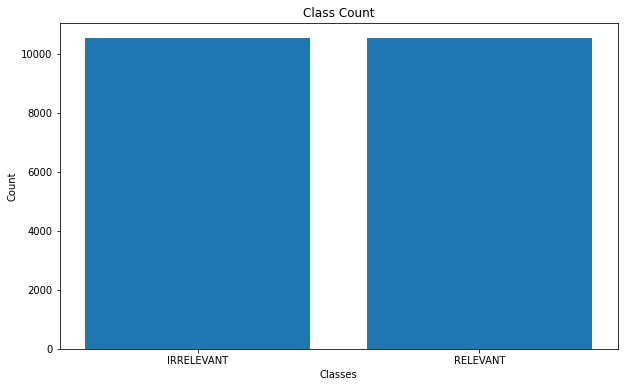

In [22]:
plot_distribution_by_class(trainset, classes)

googlenet


/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.conv.weight
	 conv1.bn.weight
	 conv1.bn.bias
	 conv2.conv.weight
	 conv2.bn.weight
	 conv2.bn.bias
	 conv3.conv.weight
	 conv3.bn.weight
	 conv3.bn.bias
	 inception3a.branch1.conv.weight
	 inception3a.branch1.bn.weight
	 inception3a.branch1.bn.bias
	 inception3a.branch2.0.conv.weight
	 inception3a.branch2.0.bn.weight
	 inception3a.branch2.0.bn.bias
	 inception3a.branch2.1.conv.weight
	 inception3a.branch2.1.bn.weight
	 inception3a.branch2.1.bn.bias
	 inception3a.branch3.0.conv.weight
	 inception3a.branch3.0.bn.weight
	 inception3a.branch3.0.bn.bias
	 inception3a.branch3.1.conv.weight
	 inception3a.branch3.1.bn.weight
	 inception3a.branch3.1.bn.bias
	 inception3a.branch4.1.conv.weight
	 inception3a.branch4.1.bn.weight
	 inception3a.branch4.1.bn.bias
	 inception3b.branch1.conv.weight
	 inception3b.branch1.bn.weight
	 inception3b.branch1.bn.bias
	 inception3b.branch2.0.conv.weight
	 inception3b.branch2.0.bn.weight
	 inception3b.branch2.0.bn.bias
	 inception3b.bra

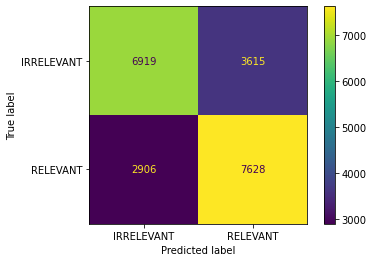

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3012 Acc: 0.8396
val Epoch Entropy: 0.7720
val Balanced Accuracy: 0.6667



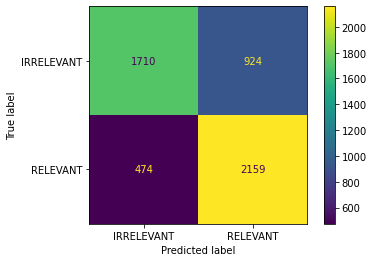

<Figure size 576x432 with 0 Axes>

Epoch 1/59
----------

train Loss: 0.5625 Acc: 0.7157
train Epoch Entropy: 0.7927
train Balanced Accuracy: 0.8333



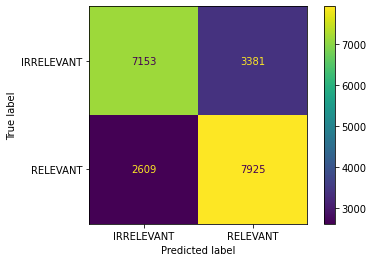

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3649 Acc: 0.8485
val Epoch Entropy: 0.8789
val Balanced Accuracy: 0.7500



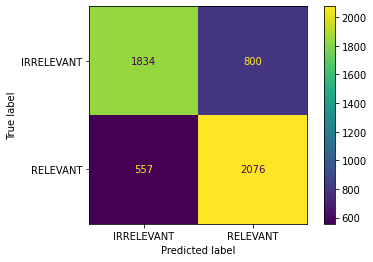

<Figure size 576x432 with 0 Axes>

Epoch 2/59
----------

train Loss: 0.5406 Acc: 0.7336
train Epoch Entropy: 0.7684
train Balanced Accuracy: 0.7500



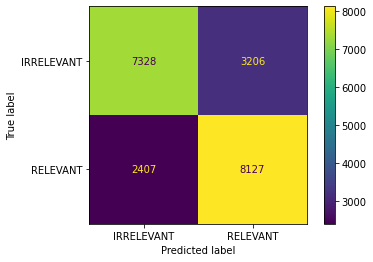

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3594 Acc: 0.8518
val Epoch Entropy: 0.8618
val Balanced Accuracy: 1.0000



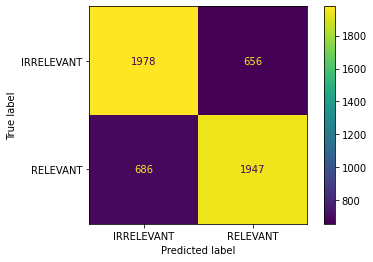

<Figure size 576x432 with 0 Axes>

Epoch 3/59
----------

train Loss: 0.5331 Acc: 0.7360
train Epoch Entropy: 0.7590
train Balanced Accuracy: 1.0000



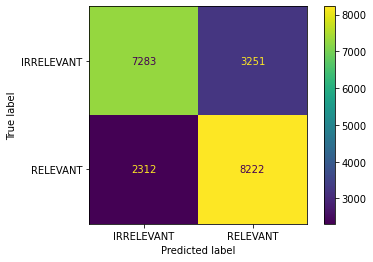

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3275 Acc: 0.8275
val Epoch Entropy: 0.7856
val Balanced Accuracy: 0.5000



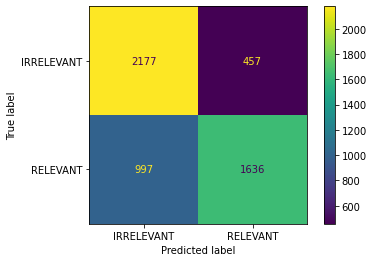

<Figure size 576x432 with 0 Axes>

Epoch 4/59
----------

train Loss: 0.5264 Acc: 0.7428
train Epoch Entropy: 0.7497
train Balanced Accuracy: 0.7500



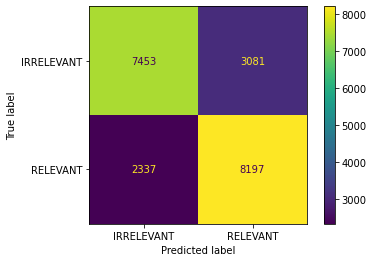

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3935 Acc: 0.8542
val Epoch Entropy: 0.9122
val Balanced Accuracy: 0.5000



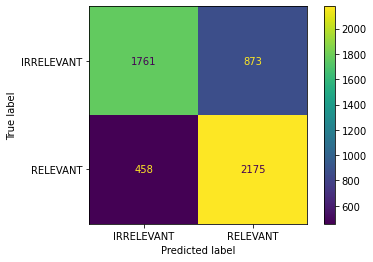

<Figure size 576x432 with 0 Axes>

Epoch 5/59
----------

train Loss: 0.5208 Acc: 0.7459
train Epoch Entropy: 0.7447
train Balanced Accuracy: 0.7500



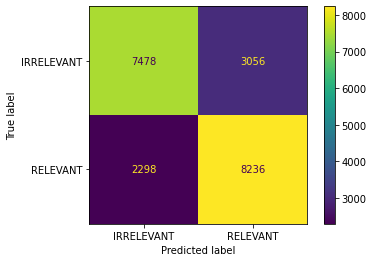

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3607 Acc: 0.8522
val Epoch Entropy: 0.8550
val Balanced Accuracy: 1.0000



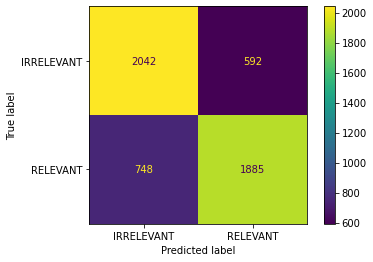

<Figure size 576x432 with 0 Axes>

Epoch 6/59
----------

train Loss: 0.5136 Acc: 0.7497
train Epoch Entropy: 0.7354
train Balanced Accuracy: 0.8333



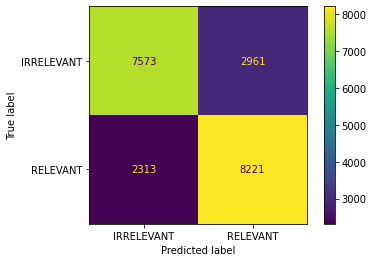

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3476 Acc: 0.8481
val Epoch Entropy: 0.8166
val Balanced Accuracy: 1.0000



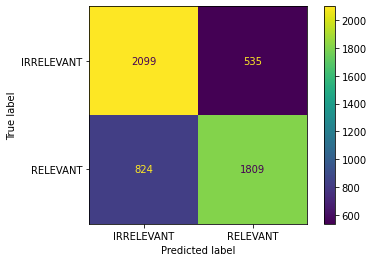

<Figure size 576x432 with 0 Axes>

Epoch 7/59
----------

train Loss: 0.4992 Acc: 0.7575
train Epoch Entropy: 0.7196
train Balanced Accuracy: 0.8333



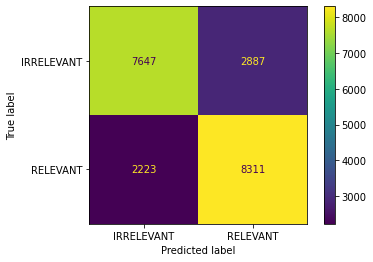

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3334 Acc: 0.8615
val Epoch Entropy: 0.8136
val Balanced Accuracy: 1.0000



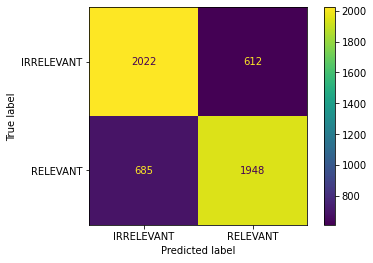

<Figure size 576x432 with 0 Axes>

Epoch 8/59
----------

train Loss: 0.4909 Acc: 0.7619
train Epoch Entropy: 0.7126
train Balanced Accuracy: 0.6667



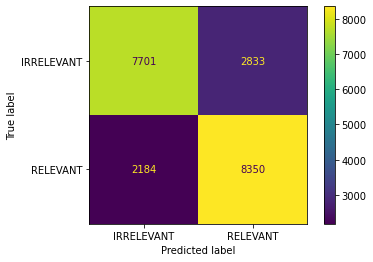

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3171 Acc: 0.8696
val Epoch Entropy: 0.7945
val Balanced Accuracy: 1.0000



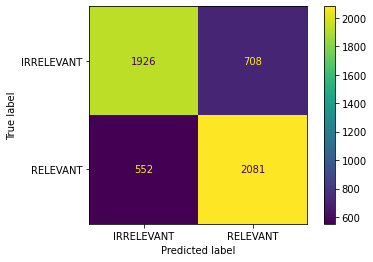

<Figure size 576x432 with 0 Axes>

Epoch 9/59
----------

train Loss: 0.4855 Acc: 0.7650
train Epoch Entropy: 0.7028
train Balanced Accuracy: 0.8333



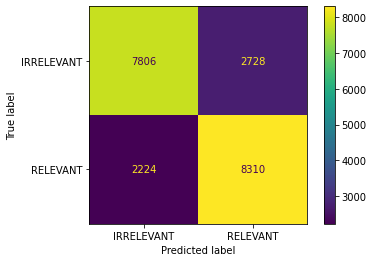

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3162 Acc: 0.8674
val Epoch Entropy: 0.7906
val Balanced Accuracy: 1.0000



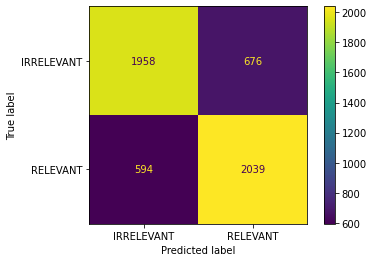

<Figure size 576x432 with 0 Axes>

Epoch 10/59
----------

train Loss: 0.4879 Acc: 0.7626
train Epoch Entropy: 0.7028
train Balanced Accuracy: 0.8333



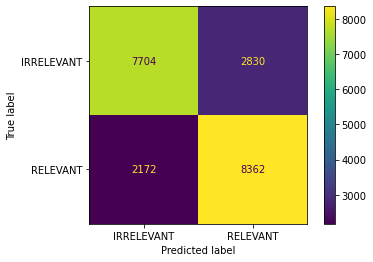

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3214 Acc: 0.8678
val Epoch Entropy: 0.7941
val Balanced Accuracy: 1.0000



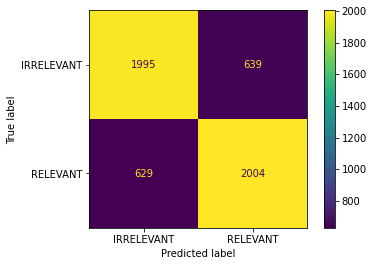

<Figure size 576x432 with 0 Axes>

Epoch 11/59
----------

train Loss: 0.4842 Acc: 0.7645
train Epoch Entropy: 0.7044
train Balanced Accuracy: 1.0000



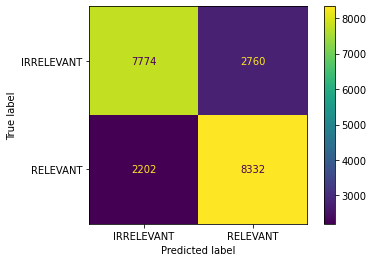

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3226 Acc: 0.8663
val Epoch Entropy: 0.7972
val Balanced Accuracy: 0.2500



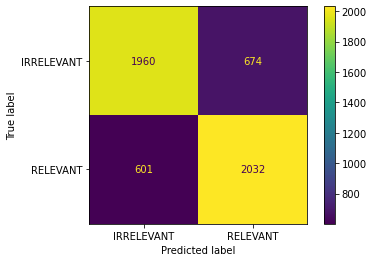

<Figure size 576x432 with 0 Axes>

Epoch 12/59
----------

train Loss: 0.4861 Acc: 0.7645
train Epoch Entropy: 0.7021
train Balanced Accuracy: 0.1667



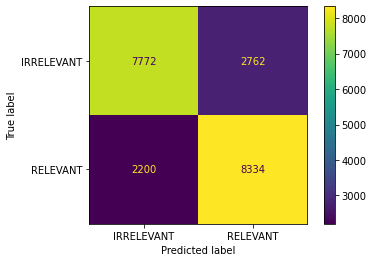

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3226 Acc: 0.8670
val Epoch Entropy: 0.7937
val Balanced Accuracy: 0.7500



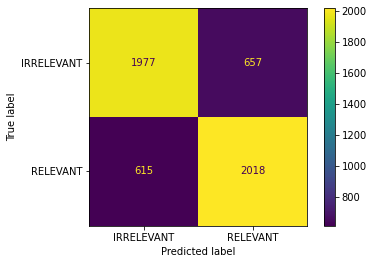

<Figure size 576x432 with 0 Axes>

Epoch 13/59
----------

train Loss: 0.4843 Acc: 0.7629
train Epoch Entropy: 0.7048
train Balanced Accuracy: 1.0000



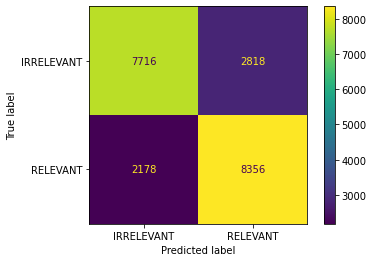

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3310 Acc: 0.8681
val Epoch Entropy: 0.8087
val Balanced Accuracy: 1.0000



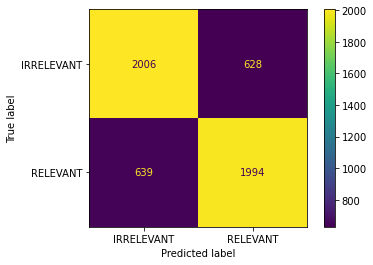

<Figure size 576x432 with 0 Axes>

Epoch 14/59
----------

train Loss: 0.4856 Acc: 0.7647
train Epoch Entropy: 0.7052
train Balanced Accuracy: 0.7500



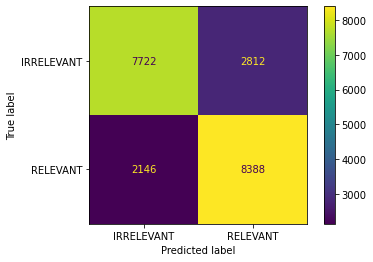

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3305 Acc: 0.8674
val Epoch Entropy: 0.8074
val Balanced Accuracy: 0.7500



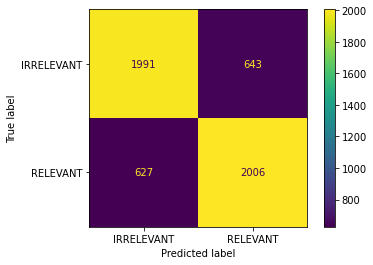

<Figure size 576x432 with 0 Axes>

Epoch 15/59
----------

train Loss: 0.4874 Acc: 0.7641
train Epoch Entropy: 0.7044
train Balanced Accuracy: 0.7500



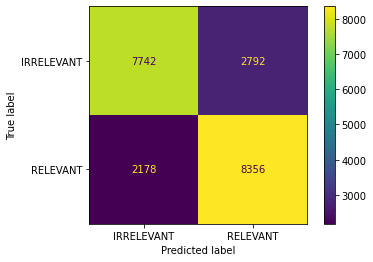

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3314 Acc: 0.8637
val Epoch Entropy: 0.8124
val Balanced Accuracy: 0.5000



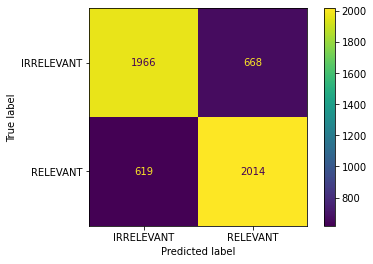

<Figure size 576x432 with 0 Axes>

Epoch 16/59
----------

train Loss: 0.4845 Acc: 0.7660
train Epoch Entropy: 0.7044
train Balanced Accuracy: 0.5000



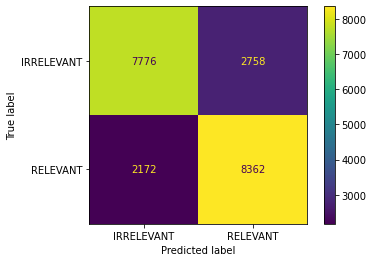

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3166 Acc: 0.8672
val Epoch Entropy: 0.7885
val Balanced Accuracy: 0.0000



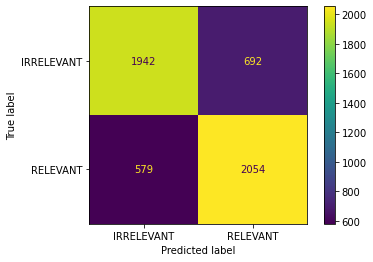

<Figure size 576x432 with 0 Axes>

Epoch 17/59
----------

train Loss: 0.4845 Acc: 0.7653
train Epoch Entropy: 0.7045
train Balanced Accuracy: 0.8333



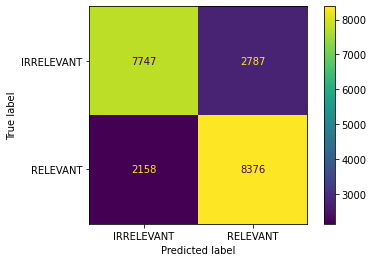

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3329 Acc: 0.8637
val Epoch Entropy: 0.8112
val Balanced Accuracy: 1.0000



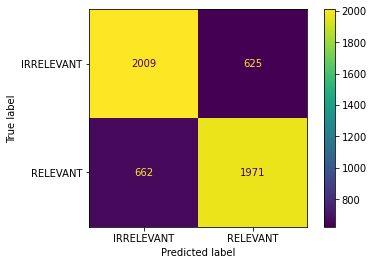

<Figure size 576x432 with 0 Axes>

Epoch 18/59
----------

train Loss: 0.4850 Acc: 0.7652
train Epoch Entropy: 0.7047
train Balanced Accuracy: 0.8333



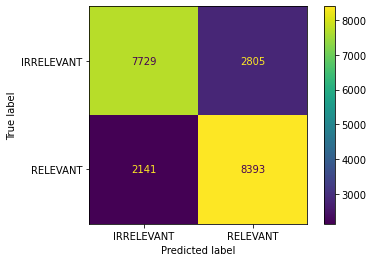

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3247 Acc: 0.8670
val Epoch Entropy: 0.7997
val Balanced Accuracy: 0.7500



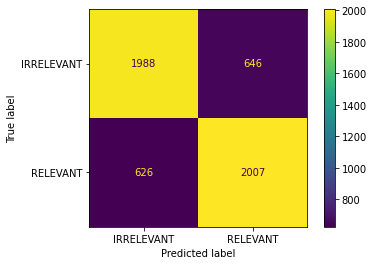

<Figure size 576x432 with 0 Axes>

Epoch 19/59
----------

train Loss: 0.4863 Acc: 0.7653
train Epoch Entropy: 0.7039
train Balanced Accuracy: 0.5000



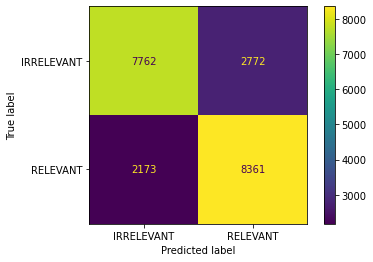

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3228 Acc: 0.8668
val Epoch Entropy: 0.7963
val Balanced Accuracy: 1.0000



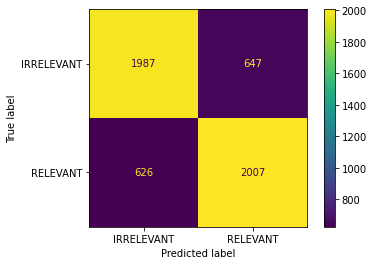

<Figure size 576x432 with 0 Axes>

Epoch 20/59
----------

train Loss: 0.4877 Acc: 0.7647
train Epoch Entropy: 0.7059
train Balanced Accuracy: 0.2500



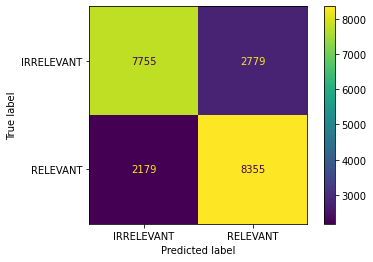

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3269 Acc: 0.8576
val Epoch Entropy: 0.7998
val Balanced Accuracy: 0.6667



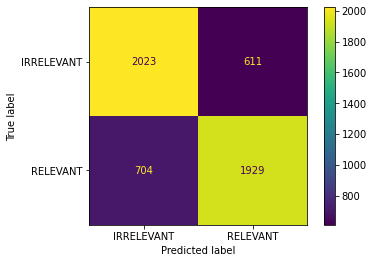

<Figure size 576x432 with 0 Axes>

Epoch 21/59
----------

train Loss: 0.4859 Acc: 0.7640
train Epoch Entropy: 0.7044
train Balanced Accuracy: 0.7500



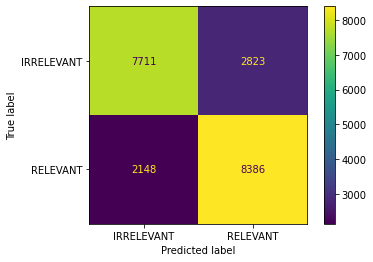

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3316 Acc: 0.8661
val Epoch Entropy: 0.8083
val Balanced Accuracy: 1.0000



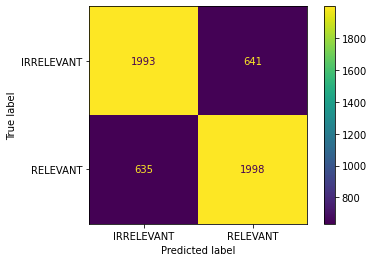

<Figure size 576x432 with 0 Axes>

Epoch 22/59
----------

train Loss: 0.4835 Acc: 0.7678
train Epoch Entropy: 0.7059
train Balanced Accuracy: 0.7500



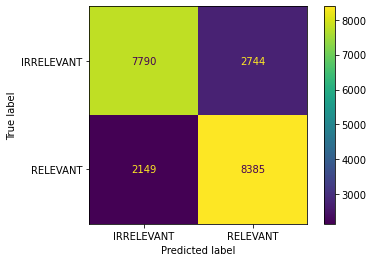

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3302 Acc: 0.8709
val Epoch Entropy: 0.8078
val Balanced Accuracy: 0.5000



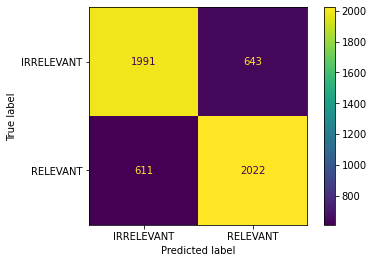

<Figure size 576x432 with 0 Axes>

Epoch 23/59
----------

train Loss: 0.4867 Acc: 0.7617
train Epoch Entropy: 0.7048
train Balanced Accuracy: 1.0000



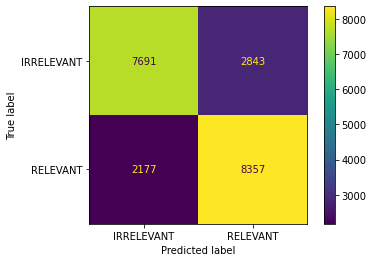

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3269 Acc: 0.8726
val Epoch Entropy: 0.8022
val Balanced Accuracy: 0.2500



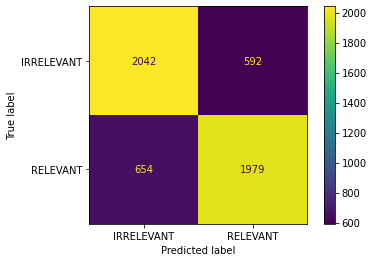

<Figure size 576x432 with 0 Axes>

Epoch 24/59
----------

train Loss: 0.4873 Acc: 0.7645
train Epoch Entropy: 0.7039
train Balanced Accuracy: 0.2500



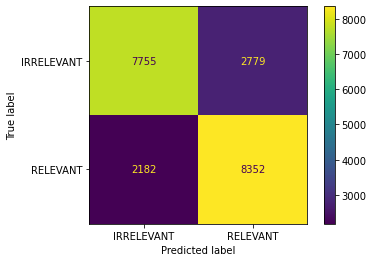

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3251 Acc: 0.8641
val Epoch Entropy: 0.7995
val Balanced Accuracy: 1.0000



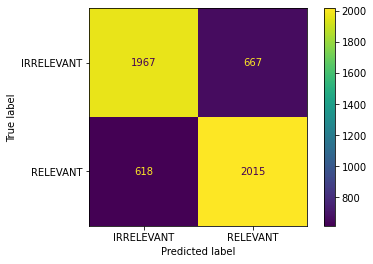

<Figure size 576x432 with 0 Axes>

Epoch 25/59
----------

train Loss: 0.4842 Acc: 0.7659
train Epoch Entropy: 0.7045
train Balanced Accuracy: 0.8333



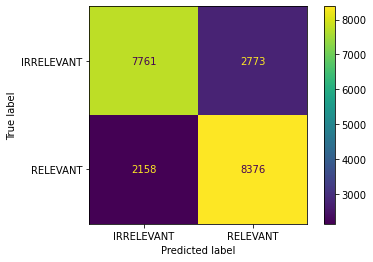

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3360 Acc: 0.8641
val Epoch Entropy: 0.8193
val Balanced Accuracy: 0.0000



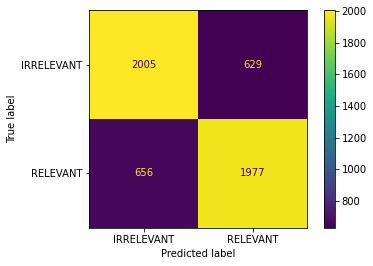

<Figure size 576x432 with 0 Axes>

Epoch 26/59
----------

train Loss: 0.4880 Acc: 0.7635
train Epoch Entropy: 0.7041
train Balanced Accuracy: 0.5000



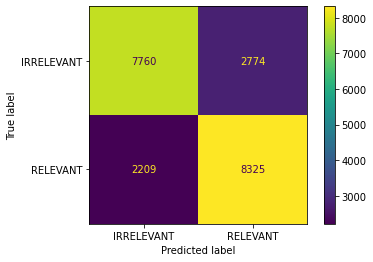

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3220 Acc: 0.8611
val Epoch Entropy: 0.7953
val Balanced Accuracy: 1.0000



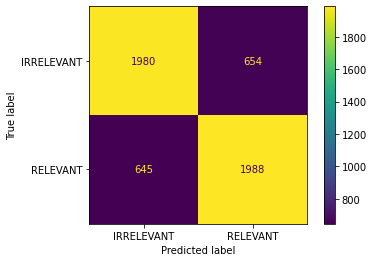

<Figure size 576x432 with 0 Axes>

Epoch 27/59
----------

train Loss: 0.4849 Acc: 0.7631
train Epoch Entropy: 0.7043
train Balanced Accuracy: 0.6667



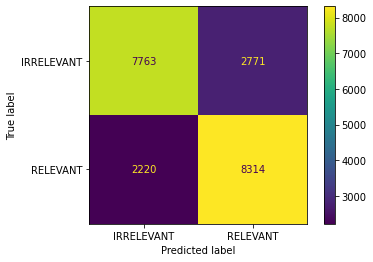

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3233 Acc: 0.8698
val Epoch Entropy: 0.7996
val Balanced Accuracy: 1.0000



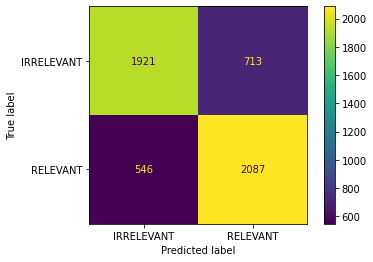

<Figure size 576x432 with 0 Axes>

Epoch 28/59
----------

train Loss: 0.4852 Acc: 0.7646
train Epoch Entropy: 0.7048
train Balanced Accuracy: 0.7500



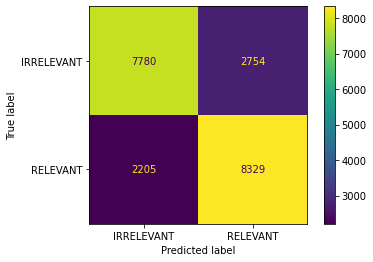

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3341 Acc: 0.8672
val Epoch Entropy: 0.8117
val Balanced Accuracy: 1.0000



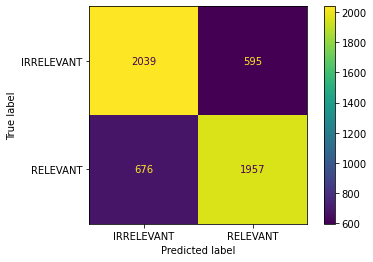

<Figure size 576x432 with 0 Axes>

Epoch 29/59
----------

train Loss: 0.4849 Acc: 0.7652
train Epoch Entropy: 0.7053
train Balanced Accuracy: 0.7500



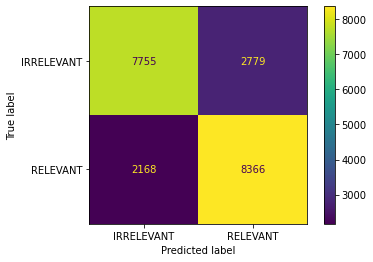

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3303 Acc: 0.8648
val Epoch Entropy: 0.8077
val Balanced Accuracy: 1.0000



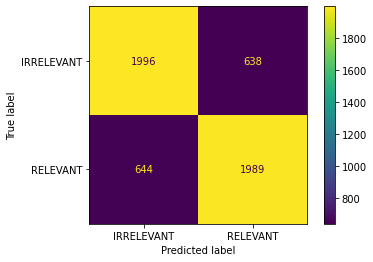

<Figure size 576x432 with 0 Axes>

Epoch 30/59
----------

train Loss: 0.4857 Acc: 0.7662
train Epoch Entropy: 0.7038
train Balanced Accuracy: 0.7500



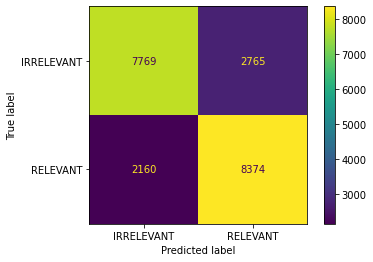

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3321 Acc: 0.8644
val Epoch Entropy: 0.8089
val Balanced Accuracy: 0.7500



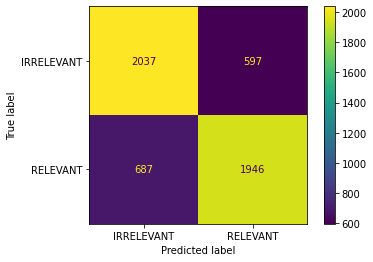

<Figure size 576x432 with 0 Axes>

Epoch 31/59
----------

train Loss: 0.4852 Acc: 0.7647
train Epoch Entropy: 0.7036
train Balanced Accuracy: 0.8333



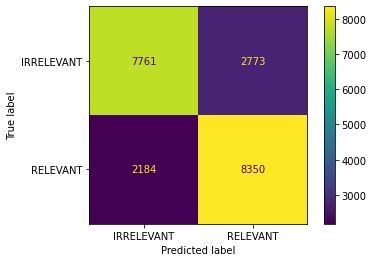

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3289 Acc: 0.8663
val Epoch Entropy: 0.8040
val Balanced Accuracy: 0.6667



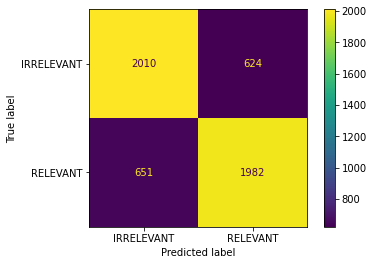

<Figure size 576x432 with 0 Axes>

Epoch 32/59
----------

train Loss: 0.4849 Acc: 0.7653
train Epoch Entropy: 0.7045
train Balanced Accuracy: 0.3333



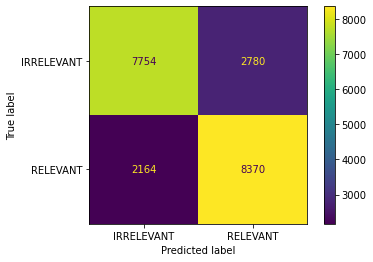

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3201 Acc: 0.8665
val Epoch Entropy: 0.7986
val Balanced Accuracy: 0.5000



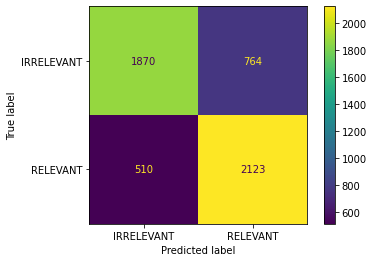

<Figure size 576x432 with 0 Axes>

Epoch 33/59
----------

train Loss: 0.4831 Acc: 0.7663
train Epoch Entropy: 0.7039
train Balanced Accuracy: 0.8333



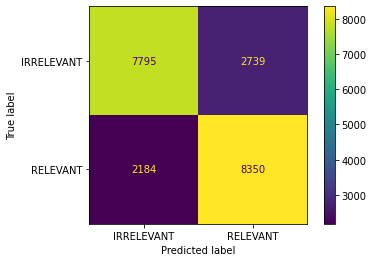

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3228 Acc: 0.8648
val Epoch Entropy: 0.8008
val Balanced Accuracy: 1.0000



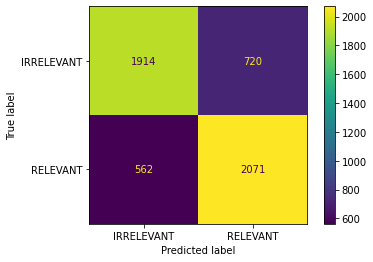

<Figure size 576x432 with 0 Axes>

Epoch 34/59
----------

train Loss: 0.4851 Acc: 0.7628
train Epoch Entropy: 0.7047
train Balanced Accuracy: 1.0000



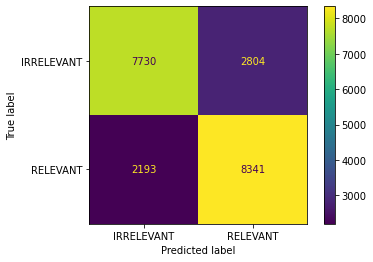

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3179 Acc: 0.8707
val Epoch Entropy: 0.7922
val Balanced Accuracy: 0.7500



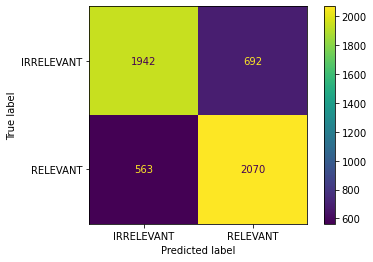

<Figure size 576x432 with 0 Axes>

Epoch 35/59
----------

train Loss: 0.4850 Acc: 0.7662
train Epoch Entropy: 0.7038
train Balanced Accuracy: 0.7500



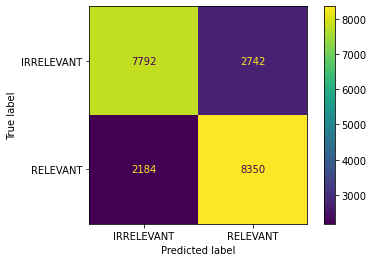

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3256 Acc: 0.8663
val Epoch Entropy: 0.7978
val Balanced Accuracy: 0.6667



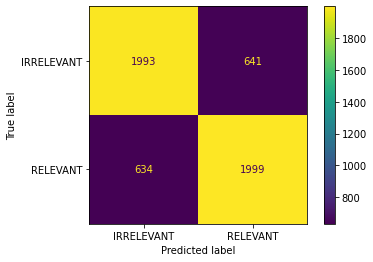

<Figure size 576x432 with 0 Axes>

Epoch 36/59
----------

train Loss: 0.4862 Acc: 0.7651
train Epoch Entropy: 0.7041
train Balanced Accuracy: 0.8333



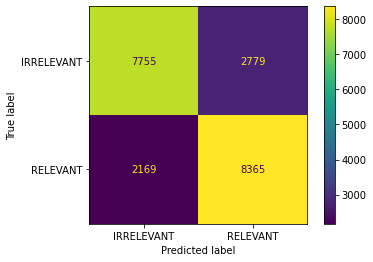

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3344 Acc: 0.8633
val Epoch Entropy: 0.8122
val Balanced Accuracy: 1.0000



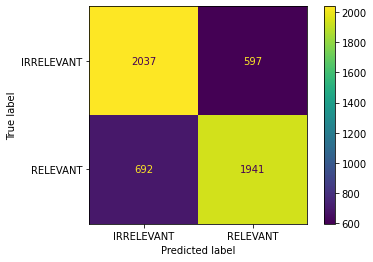

<Figure size 576x432 with 0 Axes>

Epoch 37/59
----------

train Loss: 0.4843 Acc: 0.7648
train Epoch Entropy: 0.7047
train Balanced Accuracy: 0.7500



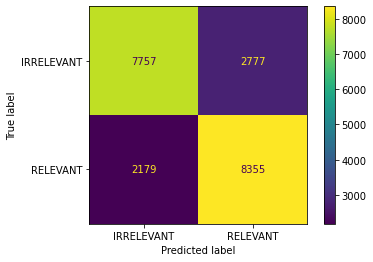

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3290 Acc: 0.8639
val Epoch Entropy: 0.8103
val Balanced Accuracy: 0.6667



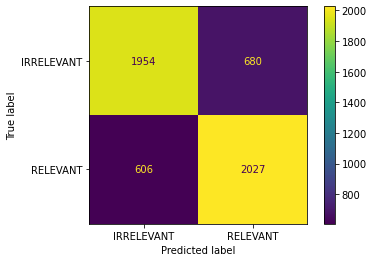

<Figure size 576x432 with 0 Axes>

Epoch 38/59
----------

train Loss: 0.4871 Acc: 0.7643
train Epoch Entropy: 0.7038
train Balanced Accuracy: 0.8333



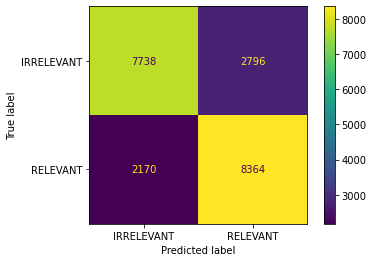

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3286 Acc: 0.8672
val Epoch Entropy: 0.8029
val Balanced Accuracy: 0.6667



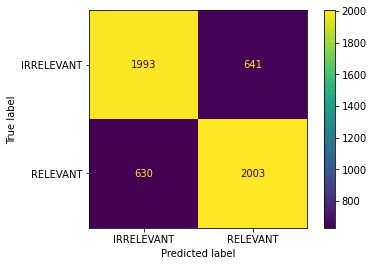

<Figure size 576x432 with 0 Axes>

Epoch 39/59
----------

train Loss: 0.4839 Acc: 0.7658
train Epoch Entropy: 0.7053
train Balanced Accuracy: 0.7500



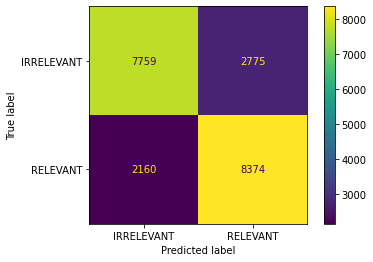

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3239 Acc: 0.8646
val Epoch Entropy: 0.7958
val Balanced Accuracy: 1.0000



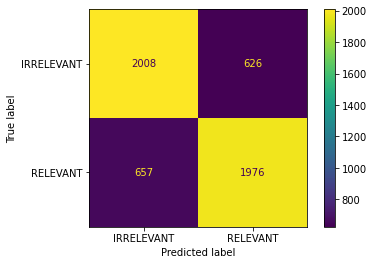

<Figure size 576x432 with 0 Axes>

Epoch 40/59
----------

train Loss: 0.4851 Acc: 0.7662
train Epoch Entropy: 0.7032
train Balanced Accuracy: 1.0000



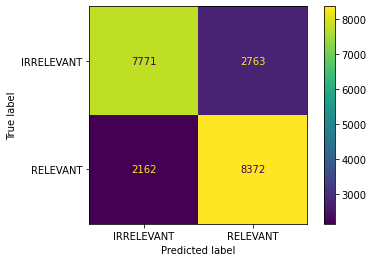

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3329 Acc: 0.8683
val Epoch Entropy: 0.8131
val Balanced Accuracy: 0.7500



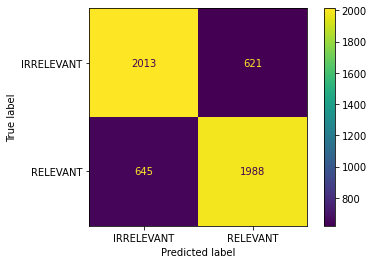

<Figure size 576x432 with 0 Axes>

Epoch 41/59
----------

train Loss: 0.4858 Acc: 0.7655
train Epoch Entropy: 0.7058
train Balanced Accuracy: 1.0000



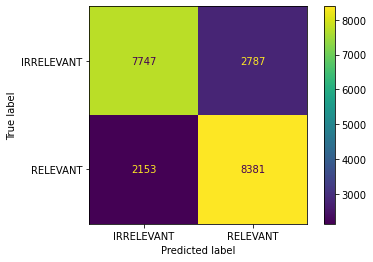

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3317 Acc: 0.8648
val Epoch Entropy: 0.8079
val Balanced Accuracy: 1.0000



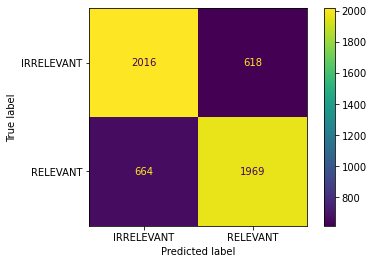

<Figure size 576x432 with 0 Axes>

Epoch 42/59
----------

train Loss: 0.4853 Acc: 0.7652
train Epoch Entropy: 0.7035
train Balanced Accuracy: 1.0000



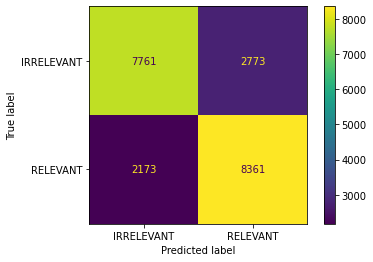

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3343 Acc: 0.8633
val Epoch Entropy: 0.8117
val Balanced Accuracy: 1.0000



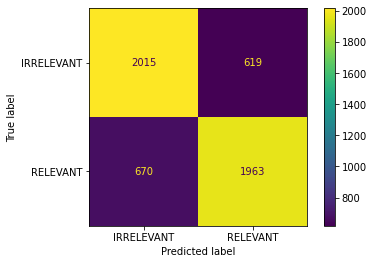

<Figure size 576x432 with 0 Axes>

Epoch 43/59
----------

train Loss: 0.4859 Acc: 0.7634
train Epoch Entropy: 0.7051
train Balanced Accuracy: 1.0000



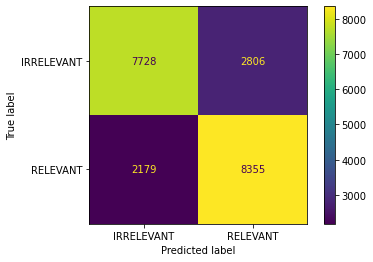

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3288 Acc: 0.8655
val Epoch Entropy: 0.8047
val Balanced Accuracy: 0.2500



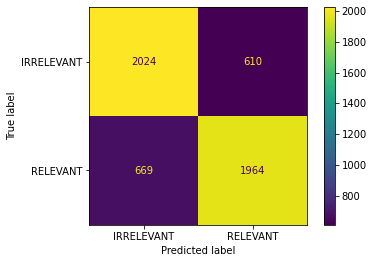

<Figure size 576x432 with 0 Axes>

Epoch 44/59
----------

train Loss: 0.4845 Acc: 0.7656
train Epoch Entropy: 0.7051
train Balanced Accuracy: 1.0000



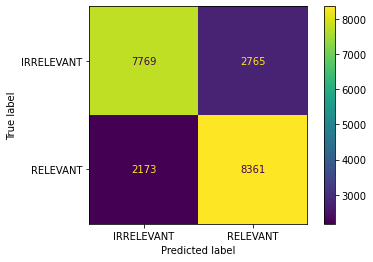

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3259 Acc: 0.8665
val Epoch Entropy: 0.8022
val Balanced Accuracy: 1.0000



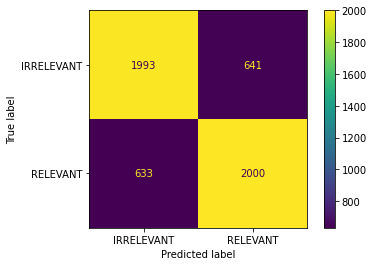

<Figure size 576x432 with 0 Axes>

Epoch 45/59
----------

train Loss: 0.4853 Acc: 0.7638
train Epoch Entropy: 0.7054
train Balanced Accuracy: 0.6667



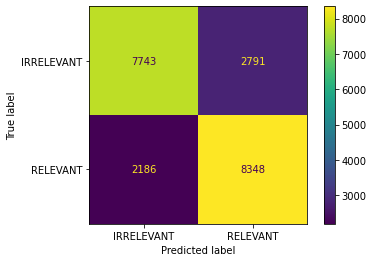

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3148 Acc: 0.8668
val Epoch Entropy: 0.7857
val Balanced Accuracy: 0.5000



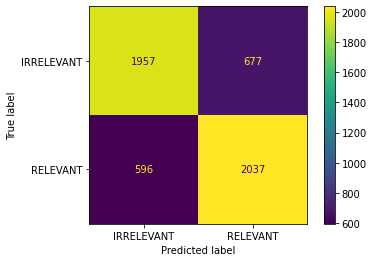

<Figure size 576x432 with 0 Axes>

Epoch 46/59
----------

train Loss: 0.4845 Acc: 0.7674
train Epoch Entropy: 0.7042
train Balanced Accuracy: 0.6667



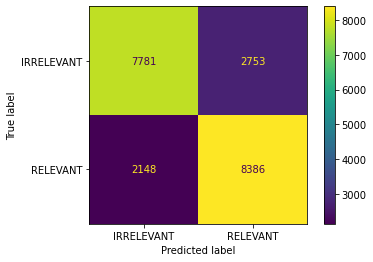

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3289 Acc: 0.8639
val Epoch Entropy: 0.8072
val Balanced Accuracy: 1.0000



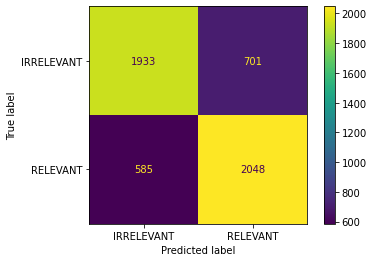

<Figure size 576x432 with 0 Axes>

Epoch 47/59
----------

train Loss: 0.4841 Acc: 0.7649
train Epoch Entropy: 0.7047
train Balanced Accuracy: 0.8333



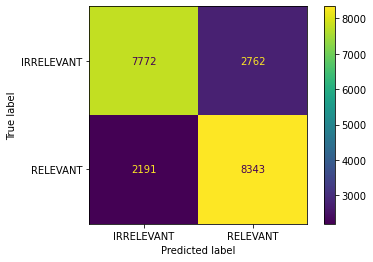

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3289 Acc: 0.8683
val Epoch Entropy: 0.8033
val Balanced Accuracy: 0.7500



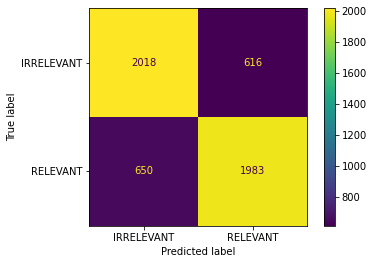

<Figure size 576x432 with 0 Axes>

Epoch 48/59
----------

train Loss: 0.4851 Acc: 0.7649
train Epoch Entropy: 0.7033
train Balanced Accuracy: 1.0000



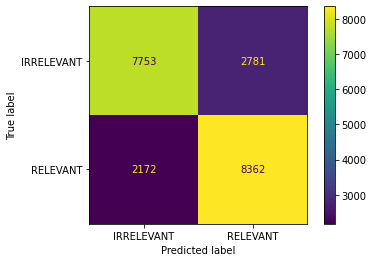

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3309 Acc: 0.8659
val Epoch Entropy: 0.8116
val Balanced Accuracy: 1.0000



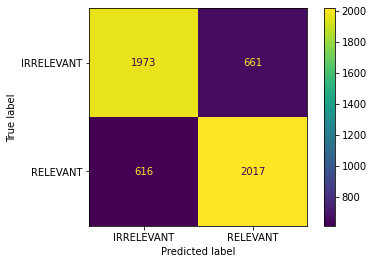

<Figure size 576x432 with 0 Axes>

Epoch 49/59
----------

train Loss: 0.4854 Acc: 0.7642
train Epoch Entropy: 0.7045
train Balanced Accuracy: 1.0000



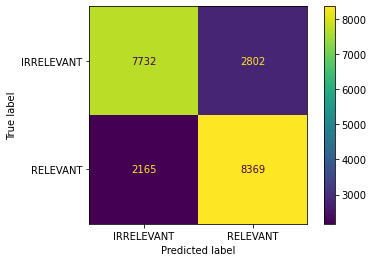

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3271 Acc: 0.8663
val Epoch Entropy: 0.8038
val Balanced Accuracy: 0.5000



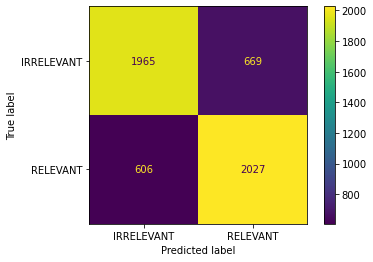

<Figure size 576x432 with 0 Axes>

Epoch 50/59
----------

train Loss: 0.4853 Acc: 0.7657
train Epoch Entropy: 0.7044
train Balanced Accuracy: 0.8333



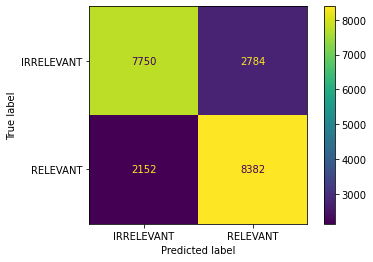

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3299 Acc: 0.8650
val Epoch Entropy: 0.8069
val Balanced Accuracy: 1.0000



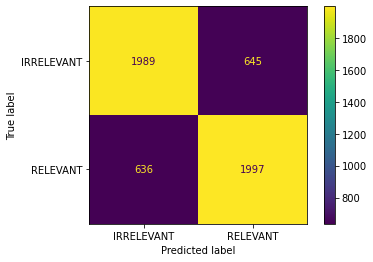

<Figure size 576x432 with 0 Axes>

Epoch 51/59
----------

train Loss: 0.4846 Acc: 0.7674
train Epoch Entropy: 0.7042
train Balanced Accuracy: 0.8333



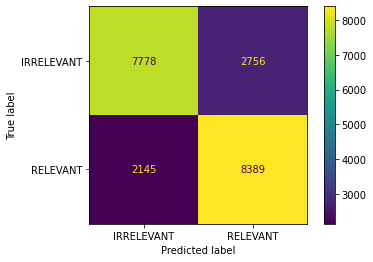

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3286 Acc: 0.8648
val Epoch Entropy: 0.8052
val Balanced Accuracy: 1.0000



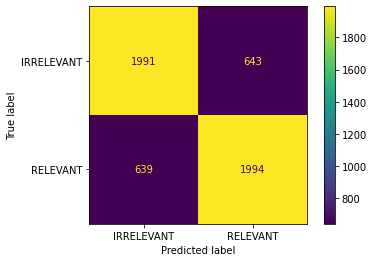

<Figure size 576x432 with 0 Axes>

Epoch 52/59
----------

train Loss: 0.4866 Acc: 0.7637
train Epoch Entropy: 0.7055
train Balanced Accuracy: 0.5000



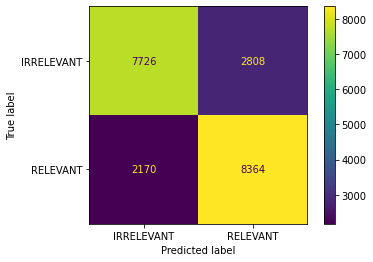

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3116 Acc: 0.8687
val Epoch Entropy: 0.7825
val Balanced Accuracy: 0.5000



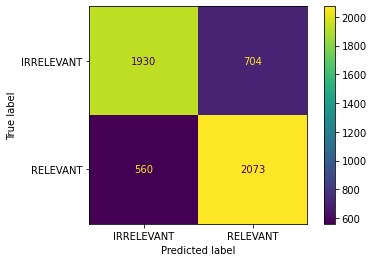

<Figure size 576x432 with 0 Axes>

Epoch 53/59
----------

train Loss: 0.4850 Acc: 0.7643
train Epoch Entropy: 0.7045
train Balanced Accuracy: 1.0000



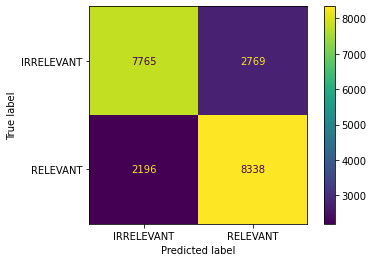

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3313 Acc: 0.8689
val Epoch Entropy: 0.8129
val Balanced Accuracy: 0.5000



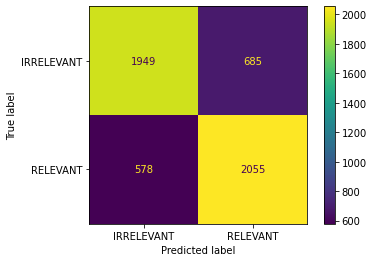

<Figure size 576x432 with 0 Axes>

Epoch 54/59
----------

train Loss: 0.4855 Acc: 0.7639
train Epoch Entropy: 0.7056
train Balanced Accuracy: 0.7500



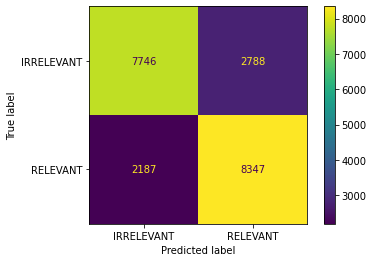

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3355 Acc: 0.8650
val Epoch Entropy: 0.8162
val Balanced Accuracy: 1.0000



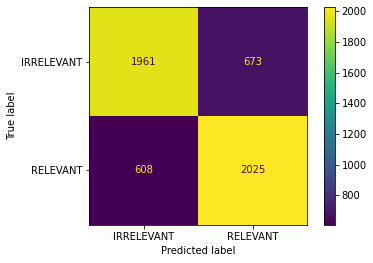

<Figure size 576x432 with 0 Axes>

Epoch 55/59
----------

train Loss: 0.4839 Acc: 0.7674
train Epoch Entropy: 0.7037
train Balanced Accuracy: 1.0000



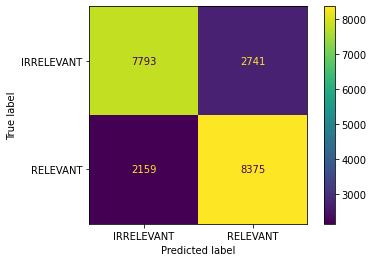

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3267 Acc: 0.8722
val Epoch Entropy: 0.8015
val Balanced Accuracy: 0.3333



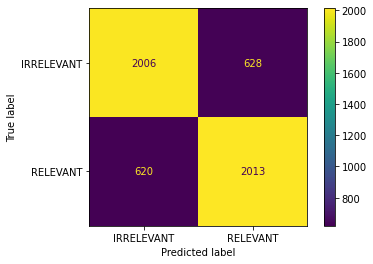

<Figure size 576x432 with 0 Axes>

Epoch 56/59
----------

train Loss: 0.4845 Acc: 0.7653
train Epoch Entropy: 0.7047
train Balanced Accuracy: 0.8333



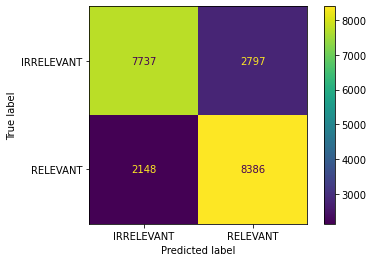

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3310 Acc: 0.8720
val Epoch Entropy: 0.8070
val Balanced Accuracy: 0.5000



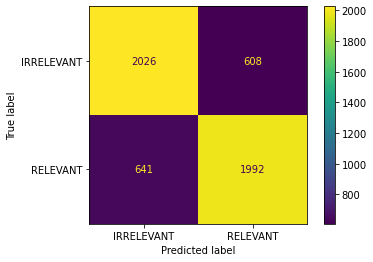

<Figure size 576x432 with 0 Axes>

Epoch 57/59
----------

train Loss: 0.4855 Acc: 0.7633
train Epoch Entropy: 0.7046
train Balanced Accuracy: 0.8333



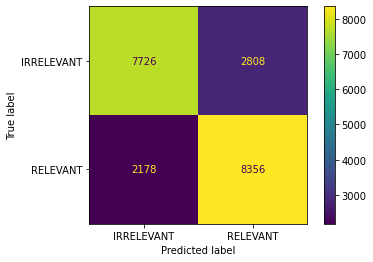

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3296 Acc: 0.8652
val Epoch Entropy: 0.8078
val Balanced Accuracy: 1.0000



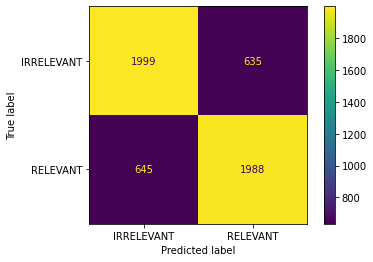

<Figure size 576x432 with 0 Axes>

Epoch 58/59
----------

train Loss: 0.4853 Acc: 0.7636
train Epoch Entropy: 0.7032
train Balanced Accuracy: 0.7500



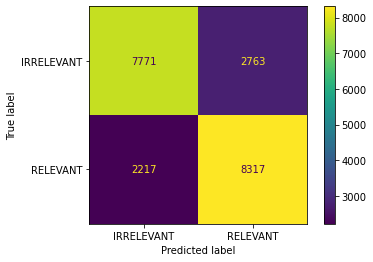

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3465 Acc: 0.8605
val Epoch Entropy: 0.8293
val Balanced Accuracy: 0.5000



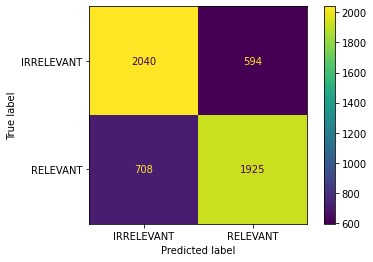

<Figure size 576x432 with 0 Axes>

Epoch 59/59
----------

train Loss: 0.4853 Acc: 0.7650
train Epoch Entropy: 0.7048
train Balanced Accuracy: 0.7500



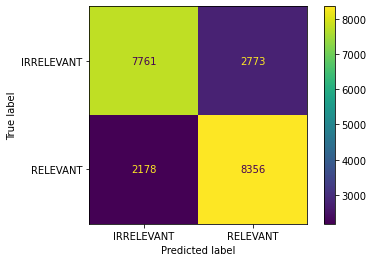

<Figure size 576x432 with 0 Axes>

Number of skipped: 659

val Loss: 0.3229 Acc: 0.8696
val Epoch Entropy: 0.7957
val Balanced Accuracy: 0.5000



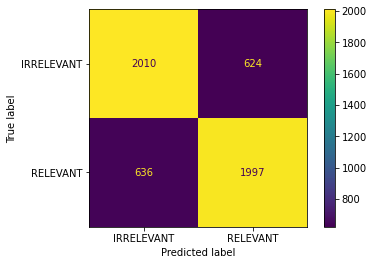

<Figure size 576x432 with 0 Axes>

Training complete in 514m 55s
Best val Acc: 0.872613
Best Val Acc. was achieved at epoch 23


In [14]:
model_list = []

for model_name in ['googlenet']:
    
    print(model_name)
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    # Observe that all parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=lr)

    exp_lr_scheduler_train = lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)
    exp_lr_scheduler_val = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-9)


    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val,E_accuracy_train,E_accuracy_val = train_model(trainset,valset,model, criterion, optimizer, exp_lr_scheduler_train,exp_lr_scheduler_val, num_epoch, bs,hardness_threshold)
    
    model_list.append(model)



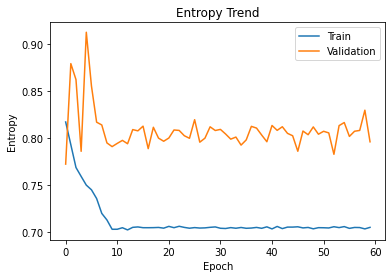

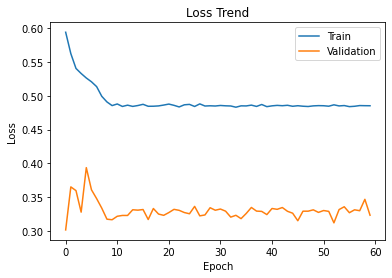

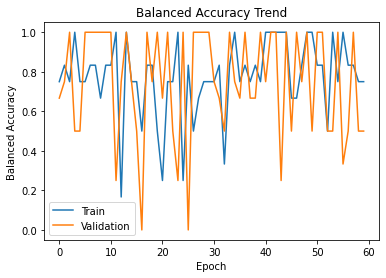

In [15]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Trend')
plt.legend()
plt.show()




In [43]:

# Assuming you have a trained model named "model"


# Define the file path to save the model
model_file1 = './model_state.pt'

# Save the model
torch.save(model.state_dict(), model_file1)

model_file2 = './model_entire.pt'

# Save the entire model
torch.save(model, model_file2)


In [40]:

# Create an instance of the ResNet50 model
model = torch.load('./model_entire.pt')

# Load the state dictionary from the model_state file
state_dict = torch.load('./model_state.pt')

# Load the state dictionary into the model
model.load_state_dict(state_dict)



<All keys matched successfully>

30
The Test Accuracy: tensor(0.8584, device='cuda:0')
The Test Balanced Accuracy: 0.7510757314974184
Skipped Inputs: 581


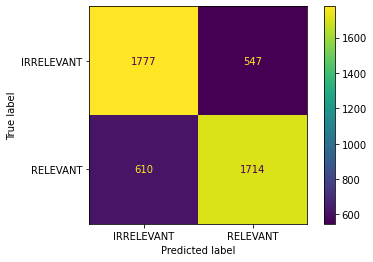

<Figure size 576x432 with 0 Axes>

35
The Test Accuracy: tensor(0.8613, device='cuda:0')
The Test Balanced Accuracy: 0.753657487091222
Skipped Inputs: 581


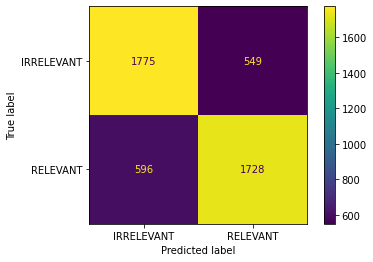

<Figure size 576x432 with 0 Axes>

40
The Test Accuracy: tensor(0.8692, device='cuda:0')
The Test Balanced Accuracy: 0.7605421686746988
Skipped Inputs: 581


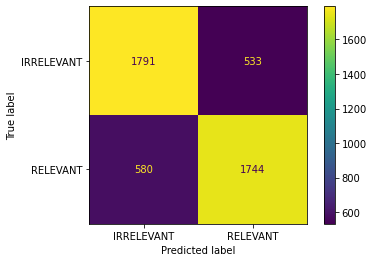

<Figure size 576x432 with 0 Axes>

60
The Test Accuracy: tensor(0.8601, device='cuda:0')
The Test Balanced Accuracy: 0.7525817555938038
Skipped Inputs: 581


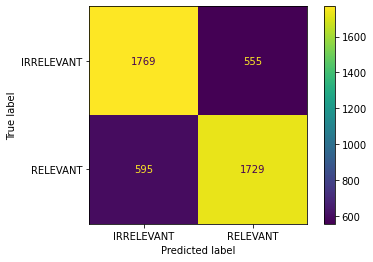

<Figure size 576x432 with 0 Axes>

75
The Test Accuracy: tensor(0.8643, device='cuda:0')
The Test Balanced Accuracy: 0.7562392426850257
Skipped Inputs: 581


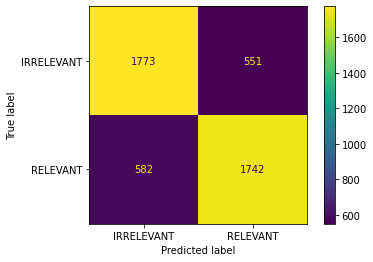

<Figure size 576x432 with 0 Axes>

In [16]:
for model in model_list:
    for hardness_threshold in [30,35,40,60,75]:
        print(hardness_threshold)
        test_model(model, testset, hardness_threshold)


In [17]:


def get_dataset_new(path,val_split,test_split):
    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset= datasets.ImageFolder(path,transform=transform_strong)

    trainset,valset,testset = stratified(dataset)
    
    print("train :",len(trainset),"val :",len(valset),"test :",len(testset))

    
    return trainset,valset,testset



In [18]:
trainset,valset,testset = get_dataset_new(path, val_size, test_size)
train_X, train_Y = weighted_score_array(model_list, trainset)
test_X, test_Y = weighted_score_array(model_list, testset)

train : 21068 val : 5267 test : 4648


In [19]:

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

Dummy Classifier Accuracy/ Random Baseline: 0.49892426850258176


Accuracy for SVM: 0.7560240963855421
Balanced Accuracy:0.7560240963855421


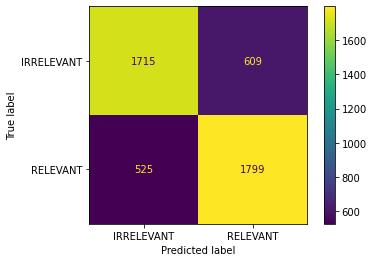

<Figure size 576x432 with 0 Axes>

In [20]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

Accuracy for MLP: 0.7553786574870912
Balanced Accuracy:0.7553786574870912


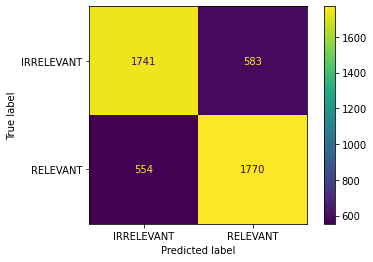

<Figure size 576x432 with 0 Axes>

In [21]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()